##Dependencies

In [ ]:
!pip install torchvision==0.14
!pip install matplotlib
!pip install "squirrel-core[torch]"
!pip install "squirrel-datasets-core[torchvision]"

!pip install transformers

I used Colab, so I saved the datasets to my Google drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Major imports used in the given sample .ipynb.

In [ ]:
import torch
from torch import nn
import torch.utils.data as tud
from torch.utils.data._utils.collate import default_collate as torch_default_collate

import torchvision.transforms as tr

import matplotlib.pyplot as plt

from squirrel.driver import MessagepackDriver
from squirrel_datasets_core.driver import TorchvisionDriver

##Dataset preparation

The evaluation and training datasets are not preprocessed here as they will be scaled and normalized later by a 'transformers' library function. 

In [ ]:
def get_dataloader_eval(batch_size: int) -> tud.DataLoader:
    """Dataloader to load evaluation/test dataset."""

    url = "/content/drive/My Drive/mmchallenge/squirrel_middlebury_patched"  # path to unzipped data folder containing *.gz files
    # Get iterator from driver
    driver = MessagepackDriver(url)
    it = driver.get_iter()

    #############################
    ## YOUR PREPROCESSING HERE ##
    preprocess = tr.Compose([
        lambda x: x
    ])
    #############################

    dataset = (
        it
        .map(preprocess)
        .batched(batch_size, torch_default_collate, drop_last_if_not_full=False)
        .to_torch_iterable()
    )
    return tud.DataLoader(dataset, shuffle=None, batch_size=None)
  
def get_dataloader_train(batch_size: int, shuffe_size: int = 100, num_workers: int = 0) -> tud.DataLoader:
    """Dataloader to Sintel training data."""
    # Path to folder containing the `Sintel` folder previously donwloaded.
    url = "/content/drive/My Drive/mmchallenge/"

    driver = TorchvisionDriver("SintelStereo", url=url)
    it = driver.get_iter()

    # Ayush: The PIL images are converted to PyTorch tensors here.
    preprocess = tr.Compose([
        lambda x: (tr.ToTensor()(x[0]), tr.ToTensor()(x[1]))
    ])

    dataset = (
        it
        .shuffle(shuffe_size)
        # .split_by_worker_pytorch()
        #############################################################
        ### YOUR PREPROCESSING, COLLATING, AUGMENTATION, ETC. HERE ##
        #############################################################
        .map(preprocess)
        .batched(batch_size, torch_default_collate, drop_last_if_not_full=True)
        .to_torch_iterable()
    )
    return tud.DataLoader(dataset, shuffle=None, batch_size=None, num_workers=num_workers)

## Extra imports

In [ ]:
from typing import Dict, List, Optional, Set, Tuple, Union

# Pretrained ViT models
from transformers import ViTFeatureExtractor, ViTModel, ViTConfig, ViTPreTrainedModel
from transformers.modeling_outputs import BaseModelOutputWithPooling, BaseModelOutput

# Similarity metric
from torch.nn import CosineSimilarity
cos = CosineSimilarity(dim=1, eps=1e-6)

##Feature extraction 
The raw images are scaled (divided by 255.) and normalized (mean=0.5 is subtracted and std. deviation=0.5 is divided), using this feature extractor function for ViT from the 'transformers' library.

In [ ]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

## Evaluation logic
This function takes the evaluation dataset, batch size and the model, and returns the matching-accuracy and confusion matrix for visualization

In [ ]:
def get_eval_performance(dl_eval, batch_size, model):
    model.eval()
    left_embeddings = torch.zeros(306, 768)
    right_embeddings = torch.zeros(306, 768)

    ## Calculate embeddings for all 306 images in the dataset and store them.
    for i, d in enumerate(dl_eval):
        bs = d["img_l"].shape[0] #The last batch may not be of length=batch_size
        
        img_l = torch.unbind(d["img_l"]) # B, 3, 360, 360
        inputs_l = feature_extractor(images=img_l, return_tensors="pt")
        inputs_l = inputs_l["pixel_values"].cuda()
        outputs_l = model(inputs_l)
        
        img_r = torch.unbind(d["img_r"])  # B, 3, 360, 360
        inputs_r = feature_extractor(images=img_r, return_tensors="pt")
        inputs_r = inputs_r["pixel_values"].cuda()
        outputs_r = model(inputs_r)

        #Pooler output contains the last hidden state for the CLS token (first token)
        left_embeddings[i * batch_size:i * batch_size + bs, :] = outputs_l.pooler_output.data.cpu()
        right_embeddings[i * batch_size:i * batch_size + bs, :] = outputs_r.pooler_output.data.cpu()

    ## Calculate the confusion matrix entries using cosine similarity metric
    match_matrix = torch.zeros(306, 306)
    accuracy = []
    for i in range(306):
        for j in range(306):
            match_matrix[i][j] = cos(left_embeddings[i:i+1], right_embeddings[j:j+1])
        match = torch.argmax(match_matrix[i:i+1], dim=1)
        if match == i:
            accuracy.append(1.)  #Correct match
        else:
            accuracy.append(0.)  #Incorrect match

    return torch.tensor(accuracy), match_matrix

##Baseline model

The baseline model is a pretrained ViT model with a patch size of 16x16 and image size of 224x224. Thus, there are 14x14 = 196 + 1(CLS) tokens in every sample

In [ ]:
ViTBase = ViTModel.from_pretrained('google/vit-base-patch16-224')
ViTBase.cuda()

x = 0
for param in ViTBase.parameters():
  if param.requires_grad == True:
    x += param.numel()

baseline_num_params = x
print("The baseline ViT model has", baseline_num_params, "parameters.")

Downloading:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The baseline ViT model has 86389248 parameters.


##Baseline performance evaluation

/usr/local/lib/python3.8/dist-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


Baseline accuracy: tensor(0.5392)
Confusion matrix:


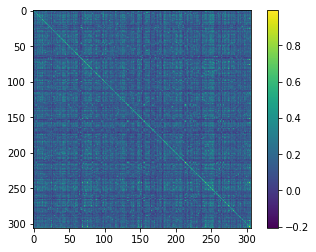

In [ ]:
batch_size = 4
dl_eval = get_dataloader_eval(batch_size)

accuracy, match_matrix = get_eval_performance(dl_eval, batch_size, ViTBase)
print("Baseline accuracy:", accuracy.mean())
print("Confusion matrix:")
plt.imshow(match_matrix)
plt.colorbar()

## Baseline augmented with Adapter system

To improve the baseline result, I wrote an Adapter class which implements the simple bottleneck method introduced in [this paper](https://arxiv.org/abs/1902.00751).

In [ ]:
class Adapter(nn.Module):
    def __init__(self, adapter_config: dict):
        super(Adapter, self).__init__()
        self.down_project = nn.Linear(adapter_config["hidden_size"], adapter_config["bottleneck_dim"])
        self.activation = adapter_config["activation"]()
        self.up_project = nn.Linear(adapter_config["bottleneck_dim"], adapter_config["hidden_size"])
        self._init_params()

    def _init_params(self):
        """Ayush: The parameters need to be initialized near zero to implement an approximate identity function"""
        for param in self.down_project.parameters():
            # torch.nn.init.constant_(param, 0.)
            torch.nn.init.normal_(param, 0., 1e-5)
        for param in self.up_project.parameters():
            # torch.nn.init.constant_(param, 0.)
            torch.nn.init.normal_(param, 0., 1e-5)

    def forward(self, hidden_states):
        # hidden_states = (B, T, D)
        outputs = self.down_project(hidden_states)
        outputs = self.activation(outputs)
        outputs = self.up_project(outputs)

        adapter_outputs = outputs + hidden_states
        return adapter_outputs

The **Adapter** class created above is then incorporated in a new class **ViTWithAdapterOutput**. This new class is basically a reproduction of the 'transformers' library class ViTOutput but with the **adapter layer** incorporated in it.

In [ ]:
class ViTWithAdapterOutput(nn.Module):
    """Ayush:
    Receives an instance of the original ViTOutput class (from transformers library) to reuse its pretrained layers.
    Uses an Adapter object to implement the modified ViTWithAdapter layer.
    """
    def __init__(self, ViTBaseOutput: nn.Module, adapter_config: dict) -> None:
        super().__init__()
        self.ViTBaseOutput = ViTBaseOutput
        self.dense = ViTBaseOutput.dense
        self.dropout = ViTBaseOutput.dropout
        self.adapter = Adapter(adapter_config)

    def forward(self, hidden_states: torch.Tensor, input_tensor: torch.Tensor) -> torch.Tensor:
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)

        #Ayush: Second adapter of the ViTWithAdapter layer implemented here (see below)
        hidden_states = self.adapter(hidden_states)

        hidden_states = hidden_states + input_tensor

        return hidden_states

The **ViTWithAdapterOutput** class created above is used in this new class **ViTWithAdapterLayer**. Again, this new class is basically a reproduction of the 'transformers' library class **ViTLayer** but with a new **output** attribute and a new **adapter** object.

In [ ]:
class ViTWithAdapterLayer(nn.Module):
    """Ayush:
    Receives an instance of the original ViTLayer class (from transformers library) to reuse its pretrained layers.
    Uses an Adapter object to implement the modified ViTWithAdapter layer.
    """
    def __init__(self, ViTBaseLayer: nn.Module, adapter_config: dict) -> None:
        super().__init__()
        #Ayush: Reuse of pretrained layers from ViTLayer class
        self.ViTBaseLayer = ViTBaseLayer
        self.chunk_size_feed_forward = ViTBaseLayer.chunk_size_feed_forward
        self.seq_len_dim = 1
        self.attention = ViTBaseLayer.attention
        self.intermediate = ViTBaseLayer.intermediate
        self.layernorm_before = ViTBaseLayer.layernorm_before
        self.layernorm_after = ViTBaseLayer.layernorm_after
        
        #Ayush: Changes the output attribute to use the previous class
        self.output = ViTWithAdapterOutput(ViTBaseLayer.output, adapter_config)
        
        #Ayush: Introduces a new adapter attribute
        self.adapter = Adapter(adapter_config)

    def forward(
        self,
        hidden_states: torch.Tensor,
        head_mask: Optional[torch.Tensor] = None,
        output_attentions: bool = False,
    ) -> Union[Tuple[torch.Tensor, torch.Tensor], Tuple[torch.Tensor]]:
        self_attention_outputs = self.attention(
            self.layernorm_before(hidden_states),  # in ViT, layernorm is applied before self-attention
            head_mask,
            output_attentions=output_attentions,
        )
        attention_output = self_attention_outputs[0]
        outputs = self_attention_outputs[1:]  # add self attentions if we output attention weights

        #Ayush: First adapter of the ViTWithAdapter layer implemented here
        adapter_output = self.adapter(attention_output)

        # first residual connection
        hidden_states = adapter_output + hidden_states

        # in ViT, layernorm is also applied after self-attention
        layer_output = self.layernorm_after(hidden_states)
        layer_output = self.intermediate(layer_output)

        # second residual connection is done here
        layer_output = self.output(layer_output, hidden_states)

        outputs = (layer_output,) + outputs

        return outputs

A new **ViTWithAdapterEncoder** class is created inspired from **ViTEncoder** which uses **ViTWithAdapterLayer** layers (created above) in place of **ViTLayer** layers.

In [ ]:
class ViTWithAdapterEncoder(nn.Module):
    """Ayush:
    Receives an instance of the original ViTEncoder class (from transformers library) to reuse its pretrained layers.
    The layers of this encoder are created using ViTWithAdapterLayer objects.
    """
    def __init__(self, ViTBaseEncoder: nn.Module, adapter_config: dict) -> None:
        super().__init__()
        self.ViTBaseEncoder = ViTBaseEncoder
        
        #Change is done here
        self.layer = nn.ModuleList([ViTWithAdapterLayer(layer, adapter_config) for layer in ViTBaseEncoder.layer])
        
        self.gradient_checkpointing = False

    def forward(
        self,
        hidden_states: torch.Tensor,
        head_mask: Optional[torch.Tensor] = None,
        output_attentions: bool = False,
        output_hidden_states: bool = False,
        return_dict: bool = True,
    ) -> Union[tuple, BaseModelOutput]:
        all_hidden_states = () if output_hidden_states else None
        all_self_attentions = () if output_attentions else None

        for i, layer_module in enumerate(self.layer):
            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            layer_head_mask = head_mask[i] if head_mask is not None else None

            if self.gradient_checkpointing and self.training:

                def create_custom_forward(module):
                    def custom_forward(*inputs):
                        return module(*inputs, output_attentions)

                    return custom_forward

                layer_outputs = torch.utils.checkpoint.checkpoint(
                    create_custom_forward(layer_module),
                    hidden_states,
                    layer_head_mask,
                )
            else:
                layer_outputs = layer_module(hidden_states, layer_head_mask, output_attentions)

            hidden_states = layer_outputs[0]

            if output_attentions:
                all_self_attentions = all_self_attentions + (layer_outputs[1],)

        if output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        if not return_dict:
            return tuple(v for v in [hidden_states, all_hidden_states, all_self_attentions] if v is not None)
        return BaseModelOutput(
            last_hidden_state=hidden_states,
            hidden_states=all_hidden_states,
            attentions=all_self_attentions,
        )

##Final ViTWithAdapterModel

Finally the **ViTWithAdapterModel** class below replaces the original **ViTModel** class, by reusing most of its implementation but changing the encoder to **ViTWithAdapterEncoder**.

In [ ]:
class ViTWithAdapterModel(nn.Module):
    def __init__(self, ViTBase: ViTPreTrainedModel, adapter_config: dict):
        super(ViTWithAdapterModel, self).__init__()
        self.ViTBase = ViTBase
        self.adapter_config = adapter_config
        self.encoder = ViTWithAdapterEncoder(ViTBase.encoder, adapter_config)
    def forward(
        self,
        pixel_values: Optional[torch.Tensor] = None,
        bool_masked_pos: Optional[torch.BoolTensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        interpolate_pos_encoding: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ):
        output_attentions = output_attentions if output_attentions is not None else self.ViTBase.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.ViTBase.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.ViTBase.config.use_return_dict

        if pixel_values is None:
            raise ValueError("You have to specify pixel_values")

        # Prepare head mask if needed
        # 1.0 in head_mask indicate we keep the head
        # attention_probs has shape bsz x n_heads x N x N
        # input head_mask has shape [num_heads] or [num_hidden_layers x num_heads]
        # and head_mask is converted to shape [num_hidden_layers x batch x num_heads x seq_length x seq_length]
        head_mask = self.ViTBase.get_head_mask(head_mask, self.ViTBase.config.num_hidden_layers)

        embedding_output = self.ViTBase.embeddings(
            pixel_values, bool_masked_pos=bool_masked_pos, interpolate_pos_encoding=interpolate_pos_encoding
        )

        encoder_outputs = self.encoder(
            embedding_output,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = encoder_outputs[0]
        sequence_output = self.ViTBase.layernorm(sequence_output)
        pooled_output = self.ViTBase.pooler(sequence_output) if self.ViTBase.pooler is not None else None

        if not return_dict:
            head_outputs = (sequence_output, pooled_output) if pooled_output is not None else (sequence_output,)
            return head_outputs + encoder_outputs[1:]

        return BaseModelOutputWithPooling(
            last_hidden_state=sequence_output,
            pooler_output=pooled_output,
            hidden_states=encoder_outputs.hidden_states,
            attentions=encoder_outputs.attentions,
        )

##Prepare for training

In [ ]:
#Training params
epochs = 3
batch_size = 64
lr = 3e-4
test_batch_size = 4

#Training dataset and testing dataset
import os
dl_train = get_dataloader_train(batch_size, num_workers=os.cpu_count())
dl_eval = get_dataloader_eval(test_batch_size)

#Model preparation

#All baseline parameters are frozen to be sure.
for param in ViTBase.parameters():
    if param.requires_grad:
        param.requires_grad = False

#The adapter configuration is chosen.
adapter_config = dict()
adapter_config["hidden_size"] = ViTBase.config.hidden_size
adapter_config["bottleneck_dim"] = 64
adapter_config["activation"] = nn.GELU

#Final model creation
model = ViTWithAdapterModel(ViTBase, adapter_config)
model.cuda()
model.train()

#Optimizer, Scheduler and loss selection
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=384, epochs=epochs, pct_start=0.1, anneal_strategy='linear', div_factor=10, final_div_factor=100)
loss_fn = nn.CosineEmbeddingLoss()

##Training loop

In [ ]:
step = 0
for epoch in range(epochs):
    for i, d in enumerate(dl_train):
        optimizer.zero_grad()
        img_l = torch.unbind(d[0])  # B, 3, 360, 360
        inputs_l = feature_extractor(images=img_l, return_tensors="pt")
        inputs_l = inputs_l["pixel_values"].cuda() # B, 197, 224

        img_r = torch.unbind(d[1])  # B, 3, 360, 360
        inputs_r = feature_extractor(images=img_r, return_tensors="pt")
        inputs_r = inputs_r["pixel_values"].cuda() # B, 197, 224

        outputs_l = model(inputs_l)
        outputs_r = model(inputs_r)

        loss = loss_fn(outputs_l.pooler_output, outputs_r.pooler_output, torch.tensor([1]).cuda())
        loss.backward()
        optimizer.step()
        # scheduler.step()
        step+=1
        if step%50 == 0:
            accuracy, match_matrix = get_eval_performance(dl_eval, test_batch_size, model)
            print(f"Model accuracy at step {step} is:", accuracy.mean())
            model.train()
          
    accuracy, match_matrix = get_eval_performance(dl_eval, test_batch_size, model)
    print(f"Model accuracy after epoch {epoch} is:", accuracy.mean())
    model.train()
    

##Final performance evaluation

In [ ]:
accuracy, match_matrix = get_eval_performance(dl_eval, test_batch_size, model)
print(f"Final model accuracy after {epoch} epochs is:", accuracy.mean())
plt.imshow(match_matrix)
plt.colorbar()


##Parameter overload over the baseline model

In [ ]:
x = 0
for param in model.parameters():
  if param.requires_grad == True:
    x += param.numel()

print(f"The new model introduces {x} more parameters over the baseline model = {(x/baseline_num_params)*100}% more params")

The new model introduces 2379264 more parameters over the baseline model = 2.754120512774923% more params
